In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from params import subject_keys, eeg_chans, run_keys
from compute_power_at_resp import power_at_resp_job
from bibliotheque import get_pos, init_nan_da, df_baseline
import mne
import os
from configuration import base_folder

In [2]:
concat = []
for run_key in run_keys:
    participant, session = run_key.split('_')
    power_at_resp_participant = power_at_resp_job.get(run_key).to_dataframe()
    concat.append(power_at_resp_participant)
power_at_resp = pd.concat(concat).reset_index(drop = True)

/tmp/ipykernel_2953365/3805491644.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(power_at_resp.corr(), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)


<AxesSubplot: >

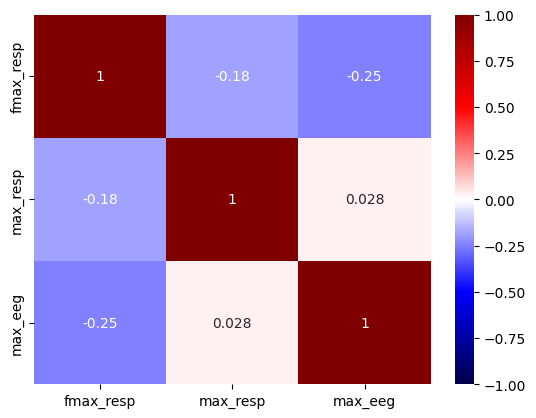

In [3]:
sns.heatmap(power_at_resp.corr(), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)

In [4]:
power_at_resp

,session,chan,participant,fmax_resp,max_resp,max_eeg
0,baseline,Fp1,P01,0.36,620.517872,1.169588e-12
1,baseline,Fz,P01,0.36,620.517872,2.607854e-13
2,baseline,F3,P01,0.36,620.517872,1.148734e-12
3,baseline,F7,P01,0.36,620.517872,4.263217e-12
4,baseline,FT9,P01,0.36,620.517872,5.405662e-12
...,...,...,...,...,...,...
646,odor,FC6,P09,0.12,1987.357188,8.294540e-12
647,odor,FC2,P09,0.12,1987.357188,4.408739e-12
648,odor,F4,P09,0.12,1987.357188,1.392254e-11
649,odor,F8,P09,0.12,1987.357188,1.210161e-11


In [5]:
power_at_resp['log_max_eeg'] = np.log(power_at_resp['max_eeg'].values)

In [6]:
indexes = ['participant','session','chan']
metrics = ['fmax_resp','max_resp','max_eeg','log_max_eeg']

In [7]:
power_at_resp_baselined = df_baseline(df = power_at_resp, indexes = indexes, metrics= metrics, mode = 'substract')

In [8]:
power_at_resp_baselined

,participant,session,chan,fmax_resp,max_resp,max_eeg,log_max_eeg
0,P01,odor,Fp1,0.0,-374.957554,-1.296162e-13,-0.117458
1,P01,odor,Fz,0.0,-374.957554,1.509711e-13,0.456734
2,P01,odor,F3,0.0,-374.957554,-5.721781e-13,-0.689344
3,P01,odor,F7,0.0,-374.957554,-2.490259e-12,-0.877375
4,P01,odor,FT9,0.0,-374.957554,-8.162423e-13,-0.163693
...,...,...,...,...,...,...,...
429,P09,music,FC6,0.0,-1276.603338,1.137124e-13,0.102391
430,P09,music,FC2,0.0,-1276.603338,-5.107334e-14,-0.118540
431,P09,music,F4,0.0,-1276.603338,9.833662e-13,0.947443
432,P09,music,F8,0.0,-1276.603338,2.017347e-13,0.109759


<AxesSubplot: xlabel='chan', ylabel='log_max_eeg'>

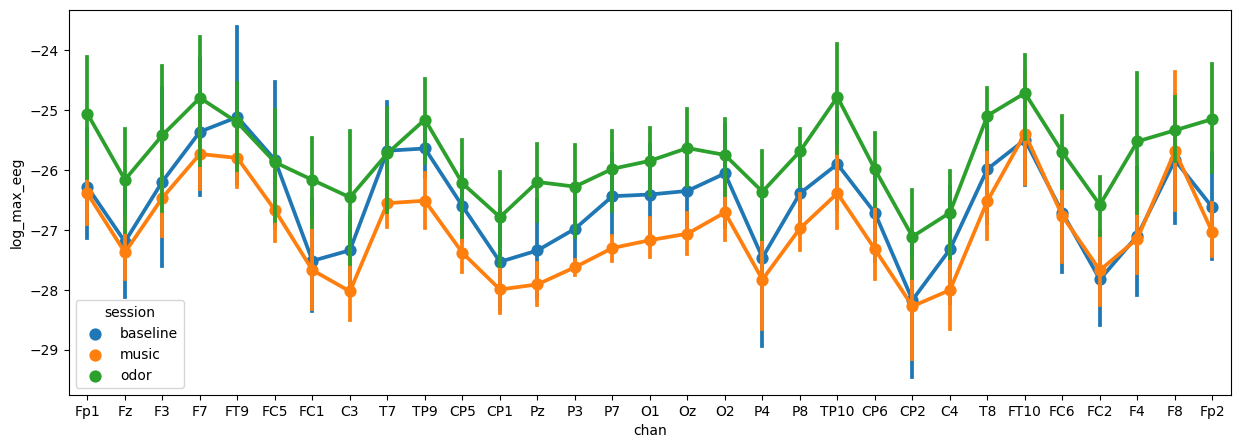

In [9]:
fig, ax = plt.subplots(figsize = (15,5))
sns.pointplot(data = power_at_resp, x = 'chan', y = 'log_max_eeg', hue = 'session',ax=ax)

<AxesSubplot: xlabel='chan', ylabel='log_max_eeg'>

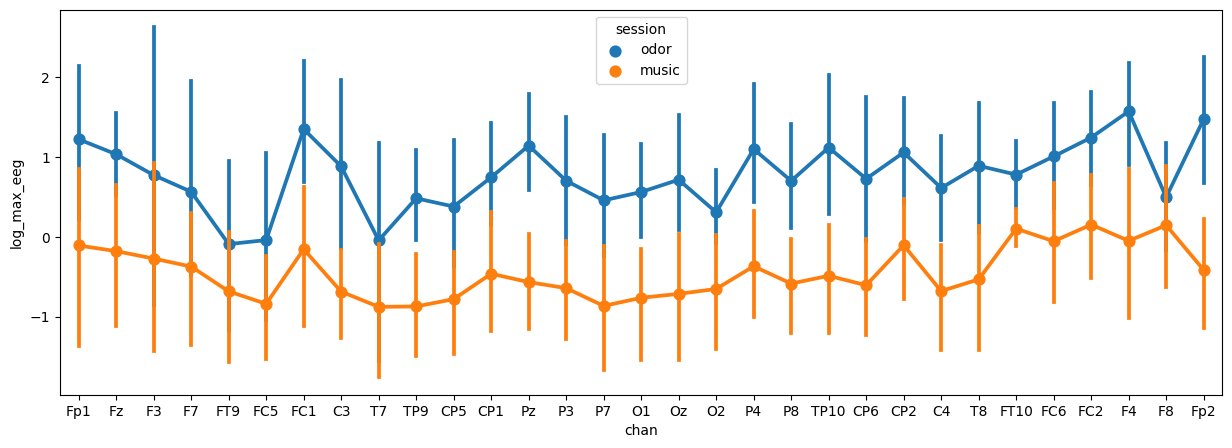

In [10]:
fig, ax = plt.subplots(figsize = (15,5))
sns.pointplot(data = power_at_resp_baselined, x = 'chan', y = 'log_max_eeg', hue = 'session',ax=ax)

SAVE


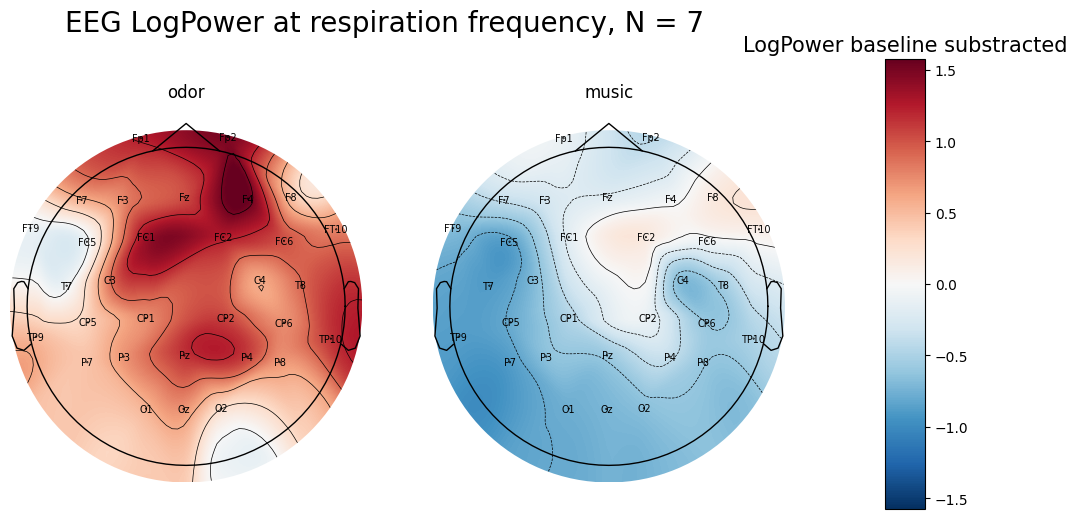

In [11]:
delta_quantile = 0.

colname = 'log_max_eeg'

df = power_at_resp_baselined

N = power_at_resp_baselined['participant'].unique().size

vmin = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, delta_quantile)
vmax = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, 1 - delta_quantile)

vmin = vmin if abs(vmin) > abs(vmax) else -vmax
vmax = vmax if abs(vmin) < abs(vmax) else abs(vmin)
    
pos = get_pos()

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG LogPower at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[colname].reindex(eeg_chans)
    im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
    ax.set_title(f'{session}')

ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('LogPower baseline substracted',fontsize=15)

file = base_folder / 'Figures' / 'power_at_resp' / 'log_substracted_to_baseline.png'

if not os.path.isfile(file):
    print('SAVE')
    fig.savefig(file, bbox_inches = 'tight')

SAVE
SAVE
SAVE
SAVE
SAVE
SAVE
SAVE


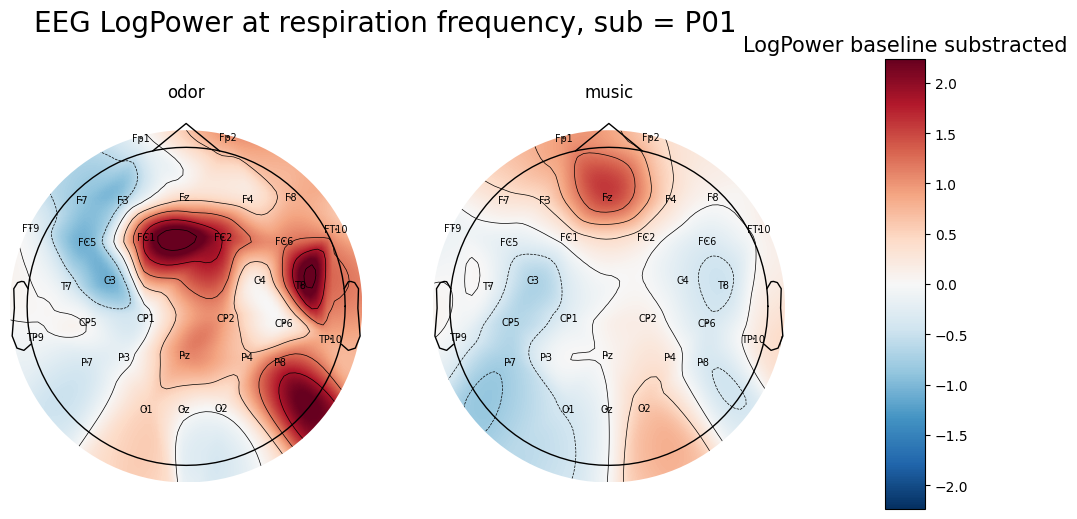

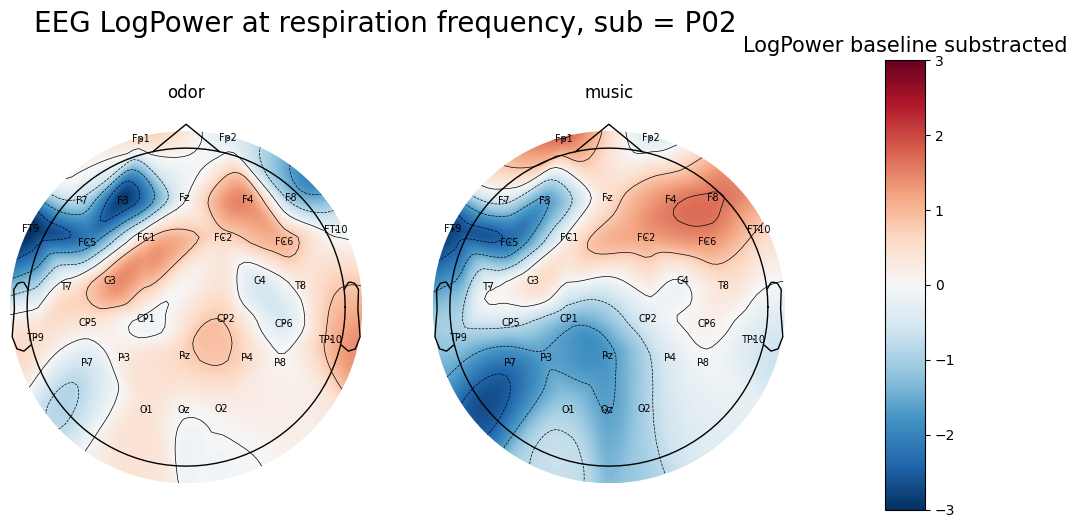

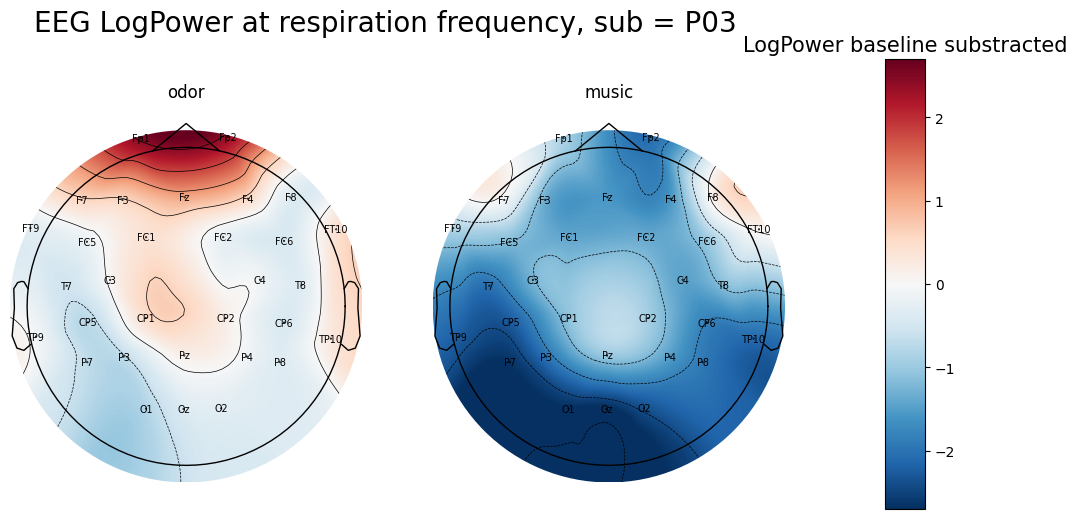

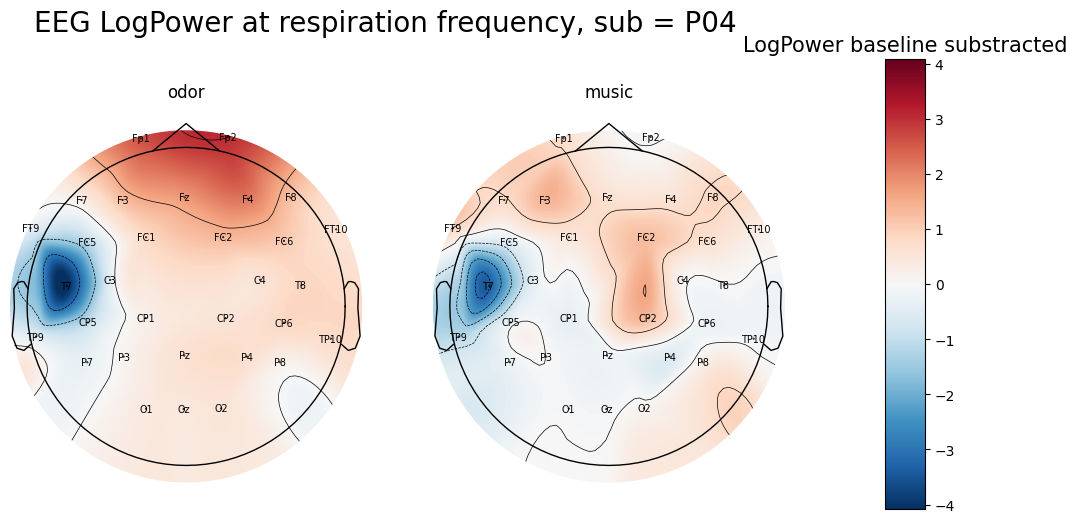

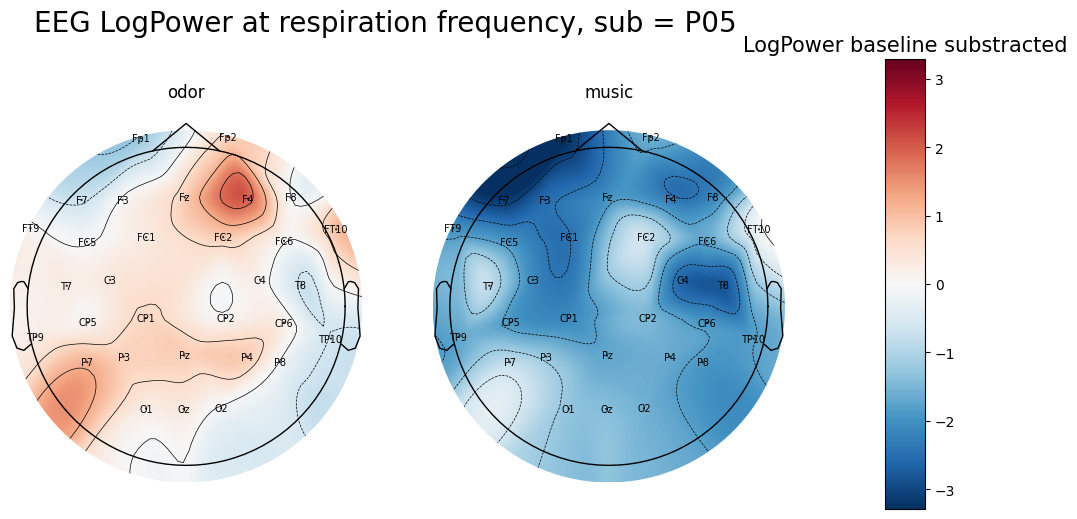

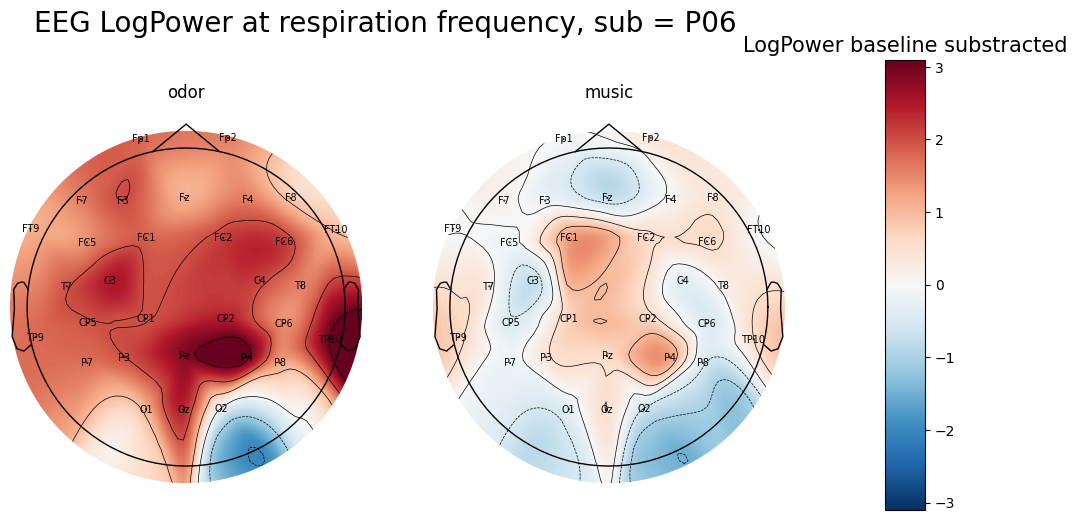

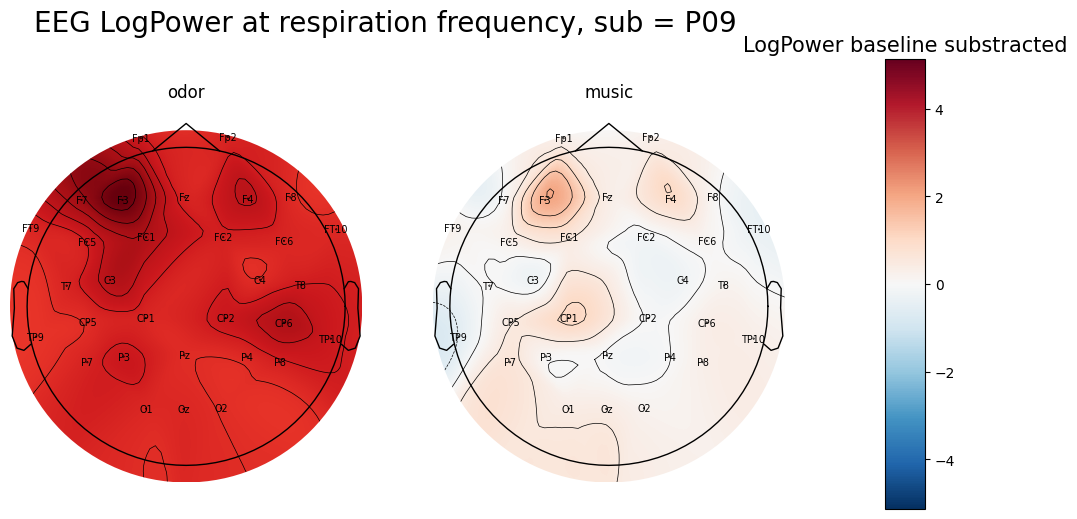

In [12]:
delta_quantile = 0.

colname = 'log_max_eeg'

for subject in subject_keys:
    
    df = power_at_resp_baselined[power_at_resp_baselined['participant'] == subject]
    
    vmin = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, delta_quantile)
    vmax = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, 1 - delta_quantile)
    
    vmin = vmin if abs(vmin) > abs(vmax) else -vmax
    vmax = vmax if abs(vmin) < abs(vmax) else abs(vmin)

    pos = get_pos()

    fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
    fig.suptitle(f'EEG LogPower at respiration frequency, sub = {subject}', fontsize = 20, y = 1.1)

    for c, session in enumerate(df['session'].unique()):
        ax = axs[c]
        topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[colname].reindex(eeg_chans)
        im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
        ax.set_title(f'{session}')

    ax_x_start = 1
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('LogPower baseline substracted',fontsize=15)

    file = base_folder / 'Figures' / 'power_at_resp' / 'by_subject' / f'{subject}.png'

    if not os.path.isfile(file):
        print('SAVE')
        fig.savefig(file, bbox_inches = 'tight')